In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from wordcloud import WordCloud
from collections import Counter
from nltk.stem import PorterStemmer, LancasterStemmer

In [2]:
def read_articles(file_name):
    with open(file_name, "r") as handle:
        article_all_lines = handle.readlines()
    
    article_all_lines = [line.replace("\n", "") for line in article_all_lines]
    
    start_art_idx = []
    for idx, line in enumerate(article_all_lines):
        if line.startswith("@"):
            start_art_idx.append(idx)
    
    idx_parirs = list(zip(start_art_idx[:-1], start_art_idx[1:])) + [(start_art_idx[-1], None)]
    #print(idx_parirs)
    articles = []
    for s_idx, e_idx in idx_parirs:
        articles.append(article_all_lines[s_idx: e_idx])
    return articles

In [3]:
def look_for_field(field, lines_per_article):
    s_idx = -1
    for idx, line in enumerate(lines_per_article):
        if line.startswith(field + " "):
            s_idx = idx
    
    e_idx = s_idx
    idx = s_idx
    while True:
        idx += 1
        if lines_per_article[idx].startswith(" "):
            e_idx = idx
        else:
            break
    e_idx += 1
    return s_idx, e_idx

In [4]:
def extract_field(field, lines_per_article):
    s_idx, e_idx = look_for_field(field, lines_per_article)
    if s_idx == -1:
        return None
    
    extracted_lines = lines_per_article[s_idx: e_idx]
    
    extracted_lines = [line.replace(field, "") for line in extracted_lines]
    extracted_lines = [line.replace("=", "") for line in extracted_lines]

    extracted_lines = [line.replace("{", "") for line in extracted_lines]
    extracted_lines = [line.replace("},", "") for line in extracted_lines]
    extracted_lines = [line.replace("}", "") for line in extracted_lines]
    
    extracted_lines = [line.strip() for line in extracted_lines]
    
    return "\n".join(extracted_lines)

In [5]:
def extract_fields(fields, lines_per_article):
    art = {field: extract_field(field, lines_per_article) for field in fields}
    return art

In [6]:
def create_pub_df(bib_file, fields):
    articles = read_articles(bib_file)
    df = [extract_fields(fields, art) for art in articles]
    return pd.DataFrame(df)

In [7]:
def remove_newlines_char(df, cols):
    for col in cols:
        df[col] = df[col].str.replace("\n", " ")
    return df

In [8]:
def remove_backward_slash(df, cols):
    for col in cols:
        df[col] = df[col].str.replace("\\", "")
    return df

In [9]:
def impute_year_none(df):
    is_year_none = df["Year"].isna()
    df.loc[is_year_none, "Year"] = df.loc[is_year_none, "Early Access Date"].apply(lambda s: s.split()[-1])
    return df

In [10]:
def nr_coauth(df, new_col_name):
    df[new_col_name] = 0
    auth_not_nan = ~df["Author"].isna()
    df.loc[auth_not_nan, new_col_name] = df.loc[auth_not_nan, "Author"].apply(lambda s: len(s.split("and")))
    return df

In [11]:
def nr_emails(df, new_col_name):
    df[new_col_name] = 0
    email_not_na = ~df["Author-Email"].isna()
    df.loc[email_not_na, new_col_name] = df.loc[email_not_na, "Author-Email"].apply(lambda s: len(s.split()))
    return df

In [12]:
def has_email(df, new_col_name, emails):
    df[new_col_name] = False
    
    email_not_na = ~df["Author-Email"].isna()
    
    for email in emails:
        df.loc[email_not_na, new_col_name] = df.loc[email_not_na, new_col_name] | df.loc[
            email_not_na, "Author-Email"].apply(lambda s: email in s)
    return df

In [13]:
def _is_reprint_auth(aff_str, auth_name):
    lines = aff_str.split("\n")
    for line in lines:
        if (auth_name in line) and ("(Reprint Author)" in line):
            return True
    return False

def is_reprint_auth(df, new_col_name, auth_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _is_reprint_auth(s, auth_name))
    return df

In [14]:
def _reprint_auth_names(aff_str):
    lines = aff_str.split("\n")
    names = []
    for line in lines:
        if "(Reprint Author)" in line:
            names.append(line.split("(Reprint Author)")[0].strip())
    names = np.unique(names)
    return "\n".join(names)

def reprint_auth_names(df, new_col_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _reprint_auth_names(s))
    return df

In [15]:
def nr_corr_auth(df, new_col_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Corr_Auth_Names"].apply(lambda s: len(s.split("\n")))
    return df

In [16]:
def _is_aff(aff_str, auth_name, inst_name_aliases):
    assert isinstance(inst_name_aliases, list), "inst_name_aliases must be a list"
    lines = aff_str.split("\n")
    for line in lines:
        for inst_name in inst_name_aliases:
            if (auth_name in line) and (inst_name in line):
                return True
    return False

def is_affiliated_with(df, new_col_name, auth_name, inst_name):
    df[new_col_name] = False
    aff_not_na = ~df["Affiliation"].isna()
    df.loc[aff_not_na, new_col_name] = df.loc[aff_not_na, "Affiliation"].apply(
        lambda s: _is_aff(s, auth_name, inst_name))
    return df

In [17]:
def _nr_self_cites(ref_str, auth_name):
    lines = ref_str.split("\n")
    nr_cites = 0
    for line in lines:
        if auth_name in line:
            nr_cites += 1
    return nr_cites

def nr_self_cites(df, new_col_name, auth_name):
    df[new_col_name] = df["Cited-References"].apply(lambda s: _nr_self_cites(s, auth_name))
    return df

In [18]:
def plot_wordcloud(word_list, ax, max_words=20, max_font_size=200, width=800, background_color="white"):
    wcloud = WordCloud(max_words=max_words, max_font_size=max_font_size, width=width, 
                       background_color=background_color).generate_from_frequencies(Counter(word_list))
    ax.imshow(wcloud, interpolation="bilinear")
    ax.axis("off")
    return ax

In [19]:
BIB_FILE = "savedrecs.bib"
FIELDS = ["Author", "Title", "Journal", "Year", "Abstract", 
          "Keywords-Plus", "Keywords", "Research-Areas", "Web-of-Science-Categories",
          "Author-Email", "Journal-ISO", "Cited-References", "Early Access Date", "Affiliation"]
df = create_pub_df(BIB_FILE, FIELDS)

cols_to_rm_newline = [col for col in df.columns if col not in ["Cited-References", "Affiliation"]]
df = remove_newlines_char(df, cols_to_rm_newline)
df = remove_backward_slash(df, df.columns)
df = impute_year_none(df)
df["Year"] = df["Year"].astype("int")

df = nr_coauth(df, "Nr_Co_Author")

df = nr_emails(df, "Nr_Emails")

df = has_email(df, "DMH_has_email", ["dominhhoat@tdtu.edu.vn", "hoat@ifuap.buap.mx"])

df = is_reprint_auth(df, "Is_DMH_Corr_Auth", "Hoat")

df = reprint_auth_names(df, "Corr_Auth_Names")

df = nr_corr_auth(df, "Nr_Corr_Auth")

df["Is_DMH_Sole_Corr_Auth"] = df["Is_DMH_Corr_Auth"] & (df["Nr_Corr_Auth"] == 1)

df["Is_DMH_Co-Corr_Auth"] = df["Is_DMH_Corr_Auth"] & (df["Nr_Corr_Auth"] > 1)

df = is_affiliated_with(df, "Is_DMH_at_TDTU", "Hoat", ["Ton Duc Thang", "Ton Duc Thong"])

df = nr_self_cites(df, "Nr_Self_Cites_DMH", "Hoat")

df.head(40)

,Abstract,Affiliation,Author,Author-Email,Cited-References,Early Access Date,Journal,Journal-ISO,Keywords,Keywords-Plus,...,Nr_Co_Author,Nr_Emails,DMH_has_email,Is_DMH_Corr_Auth,Corr_Auth_Names,Nr_Corr_Auth,Is_DMH_Sole_Corr_Auth,Is_DMH_Co-Corr_Auth,Is_DMH_at_TDTU,Nr_Self_Cites_DMH
0,We study comprehensively the uniform strain ef...,"Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Naseri, Mosayeb and Hoat, D. M. and Ponce-Pere...",m.naseri@iauksh.ac.ir dominhhoat@tdtu.edu.vn r...,"Ahmad M, 2017, J ALLOY COMPD, V705, P828, DOI ...",None,CHEMICAL PHYSICS,Chem. Phys.,FP-LAPW calculations; CsPbCl3; Strain effect; ...,ORGANIC-INORGANIC PEROVSKITES; THERMODYNAMIC P...,...,5,4,True,True,"Hoat, DM",1,True,False,True,5
1,Two dimensional monolayer semiconductors play ...,"Naseri, M (Reprint Author), Islamic Azad Univ,...","Naseri, Mosayeb and Hoat, D. M. and Salehi, Kh...",m.naseri@iauksh.ac.ir dominhhoat@tdtu.edu.vn,"Balendhran S, 2015, SMALL, V11, P640, DOI 10.1...",None,JOURNAL OF MOLECULAR GRAPHICS & MODELLING,J. Mol. Graph.,2D material; XI2 monolayer; Indirect semicondu...,ELECTRONIC-PROPERTIES; BE2C MONOLAYER; STRAIN;...,...,4,2,True,True,"Hoat, DM\nNaseri, M",2,False,True,True,1
2,"In this work, we study the electronic, optical...","Binh, NTT (Reprint Author), Duy Tan Univ, Inst...","Vu, Tuan V. and Nguyen Thi Tuyet Anh and Hoat,...",vuvantuan@tdtu.edu.vn nguyentthanhbinh8@duytan...,"Atag S, 2009, PHYS REV D, V80, DOI 10.1103/Phy...",None,PHYSICA E-LOW-DIMENSIONAL SYSTEMS & NANOSTRUCT...,Physica E,Monolayer germanium carbide; Fully hydrogenati...,STRAIN,...,11,3,False,False,"Binh, NTT",1,False,False,True,2
3,"In recent years, the scientific community has ...","Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M.",dominhhoat@tdtu.edu.vn,"Addadi Z, 2017, J SUPERCOND NOV MAGN, V30, P91...",FEB 2020,PHILOSOPHICAL MAGAZINE LETTERS,Philos. Mag. Lett.,Diluted semiconductor; half-metallicity; elect...,QUANTUM DOTS; ZNO; FERROMAGNETISM; FE; CO,...,1,1,True,True,"Hoat, DM",1,True,False,True,0
4,"In this paper, we report results of the struct...","Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M. and Naseri, Mosayeb and Ponce-Pere...",dominhhoat@tdtu.edu.vn m.naseri@iauksh.ac.ir r...,"Ambrosch-Draxl C, 2006, COMPUT PHYS COMMUN, V1...",None,JOURNAL OF SOLID STATE CHEMISTRY,J. Solid State Chem.,FP-LAPW method; CdIn(2)Se(4)compound; Structur...,THERMODYNAMIC PROPERTIES; REFRACTIVE-INDEX; EN...,...,5,4,True,True,"Hoat, DM",1,True,False,True,4
5,"In this work, we investigate the electronic an...","Vu, TV (Reprint Author), Ton Duc Thang Univ, I...","Nguyen, Hong T. T. and Vu, Tuan V. and Binh, N...",nguyenthithamhong@tdtu.edu.vn vuvantuan@tdtu.e...,"Akbudak S, 2018, J SUPERCOND NOV MAGN, V31, P3...",None,CHEMICAL PHYSICS,Chem. Phys.,Monolayer GeSe; Electronic and optical propert...,PHASE-TRANSITION; BIAXIAL STRAIN; SNSE,...,11,5,True,False,"Binh, NTT; Hieu, NN\nVu, TV",2,False,False,True,0
6,First-principles total energy calculations bas...,"Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M. and Naseri, Mosayeb and Hieu, Nguy...",dominhhoat@tdtu.edu.vn m.naseri@iaulcsh.ac.ir ...,"Allen MJ, 2010, CHEM REV, V110, P132, DOI 10.1...",None,SUPERLATTICES AND MICROSTRUCTURES,Superlattices Microstruct.,First-principles study; SiC monolayer; Chemica...,ELECTRONIC-PROPERTIES; OPTICAL-PROPERTIES; GRA...,...,6,5,True,True,"Hieu, NN\nHoat, DM",2,False,True,True,0
7,Boron nitride (BN) monolayer (ML) has been the...,"Hoat, DM (Reprint Author), Ton Duc Thang Univ,...","Hoat, D. M. and Naseri, Mosayeb and Ponce-Pere...",dominhhoat@tdtu.edu.vn m.naseri@iauksh.ac.ir r...,"Al-Abbas SSA, 2019, SUPERLATTICE MICROST, V135...",None,SUPERLATTICES AND MICROSTRUCTURES,Superlattices Microstruct.,First-principles study; BN monolayer; Band gap...,TRANSITION-METAL DICHALCOGENIDES; OPTICAL-PROP...,...,7,6,True,True,"Hieu, NN\nHoat, DM",2,False,True,True,3
8,"In this work, we systematically investigate th...","Binh, NTT (Reprint Author), 

In [28]:
df.to_csv("wos_data_DMH.csv")

# Number of publications

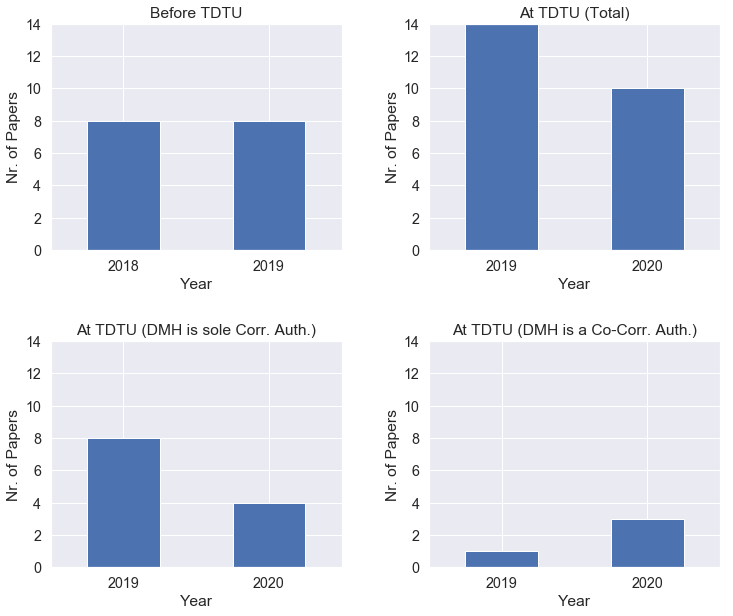

In [20]:
sns.set(font_scale=1.3)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.4)

at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

rows = [~at_tdtu, at_tdtu, at_tdtu & sole_corr_auth, at_tdtu & co_corr_auth]
titles = ["Before TDTU", "At TDTU (Total)", "At TDTU (DMH is sole Corr. Auth.)", "At TDTU (DMH is a Co-Corr. Auth.)"]

for ax, row, title in zip(axes, rows, titles):
    ser = df.loc[row, "Year"].value_counts().sort_index()
    ser.plot(kind="bar", ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("Nr. of Papers")
    ax.set_ylim([0, 14])
    ax.set_xticklabels(ser.index.to_list(), rotation=0)
    ax.set_title(title)

# Average number of co-authors per paper

Text(0.5,0,'Average number of co-authors per paper')

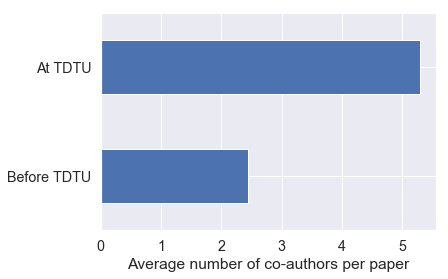

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
df.groupby("Is_DMH_at_TDTU")["Nr_Co_Author"].mean().plot(kind="barh", ax=ax)
ax.set_yticklabels(["Before TDTU", "At TDTU"])
ax.set_ylabel("")
ax.set_xlabel("Average number of co-authors per paper")

# Most frequent journals

Text(0.5,1,'At TDTU and DMH is a co-corr. auth.')

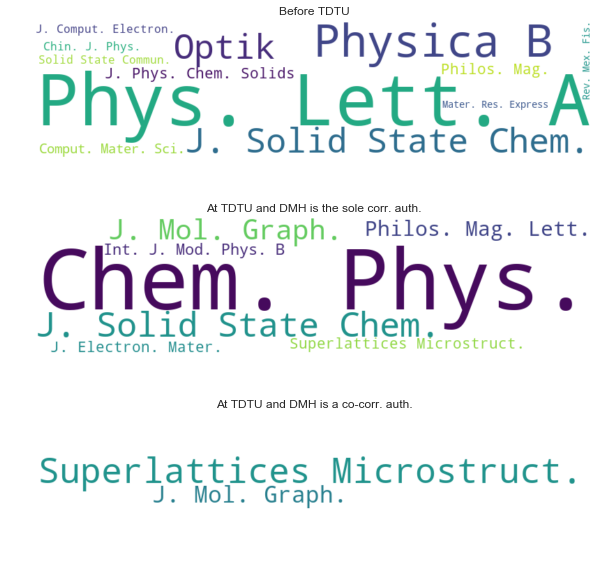

In [22]:
at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

j_b_tdtu = df.loc[~at_tdtu, "Journal-ISO"].to_list()
j_a_tdtu_sole = df.loc[at_tdtu & sole_corr_auth, "Journal-ISO"].to_list()
j_a_tdtu_co = df.loc[at_tdtu & co_corr_auth, "Journal-ISO"].to_list()

sns.set(font_scale=1.0)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

plot_wordcloud(j_b_tdtu, ax[0]) 
ax[0].set_title("Before TDTU")

plot_wordcloud(j_a_tdtu_sole, ax[1]) 
ax[1].set_title("At TDTU and DMH is the sole corr. auth.")

plot_wordcloud(j_a_tdtu_co, ax[2]) 
ax[2].set_title("At TDTU and DMH is a co-corr. auth.")

# Most common research areas

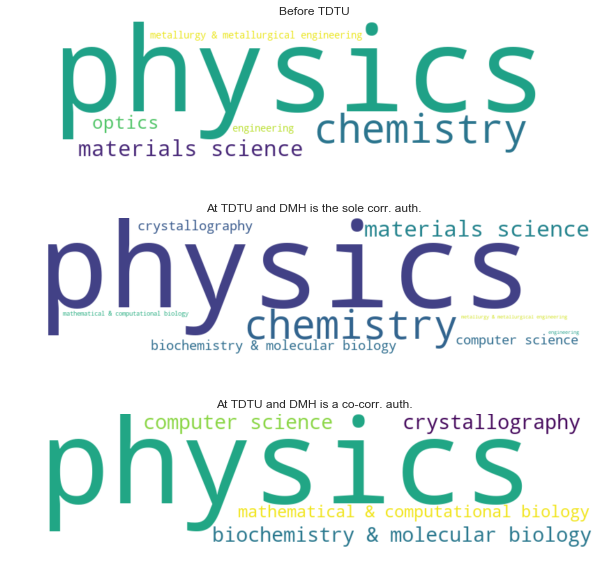

In [23]:
at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

rows = [~at_tdtu, at_tdtu & sole_corr_auth, at_tdtu & co_corr_auth]
titles = ["Before TDTU", "At TDTU and DMH is the sole corr. auth.", "At TDTU and DMH is a co-corr. auth."]

sns.set(font_scale=1.0)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

for ax, row, title in zip(axes, rows, titles):
    wlist = []
    for s in df.loc[row, "Research-Areas"].values:
        wlist.extend(s.split(";"))
    wlist = [s.strip().lower() for s in wlist]
    plot_wordcloud(wlist, ax)
    ax.set_title(title)

# Most common Web-of-Science Categories

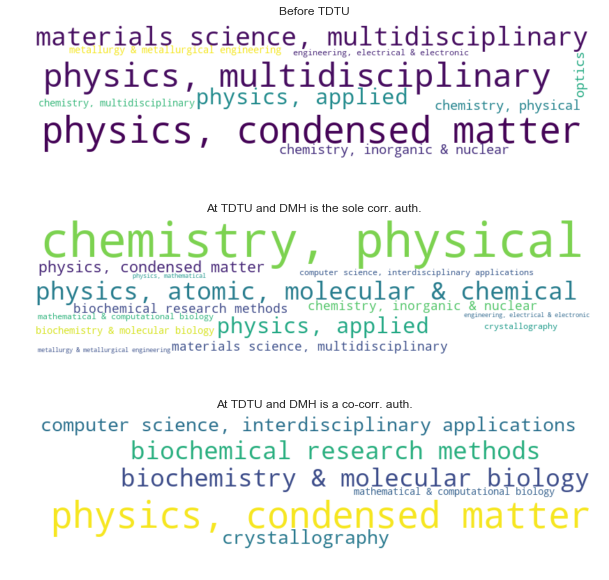

In [24]:
at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

rows = [~at_tdtu, at_tdtu & sole_corr_auth, at_tdtu & co_corr_auth]
titles = ["Before TDTU", "At TDTU and DMH is the sole corr. auth.", "At TDTU and DMH is a co-corr. auth."]

sns.set(font_scale=1.0)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

for ax, row, title in zip(axes, rows, titles):
    wlist = []
    for s in df.loc[row, "Web-of-Science-Categories"].values:
        wlist.extend(s.split(";"))
    wlist = [s.strip().lower() for s in wlist]
    plot_wordcloud(wlist, ax)
    ax.set_title(title)

# Most frequently occurring keywords

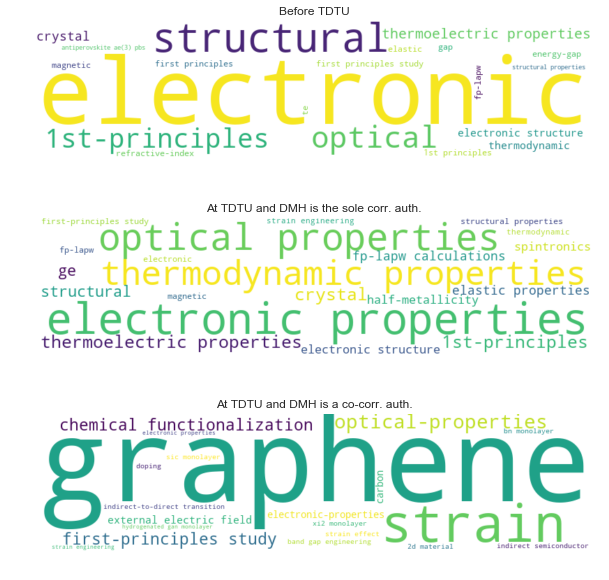

In [25]:
at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

rows = [~at_tdtu, at_tdtu & sole_corr_auth, at_tdtu & co_corr_auth]
titles = ["Before TDTU", "At TDTU and DMH is the sole corr. auth.", "At TDTU and DMH is a co-corr. auth."]

sns.set(font_scale=1.0)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.3)

for ax, row, title in zip(axes, rows, titles):
    wlist = []
    for s in df.loc[row, "Keywords"].dropna().values:
        wlist.extend(s.split(";"))
    for s in df.loc[row, "Keywords-Plus"].dropna().values:
        wlist.extend(s.split(";"))
        
    wlist = [s.strip().lower() for s in wlist]
    plot_wordcloud(wlist, ax)
    ax.set_title(title)

# Most frequent co-corresponding authors 
Among papers in which D.M.H. is a corresponding author, who else are also corresponding author?

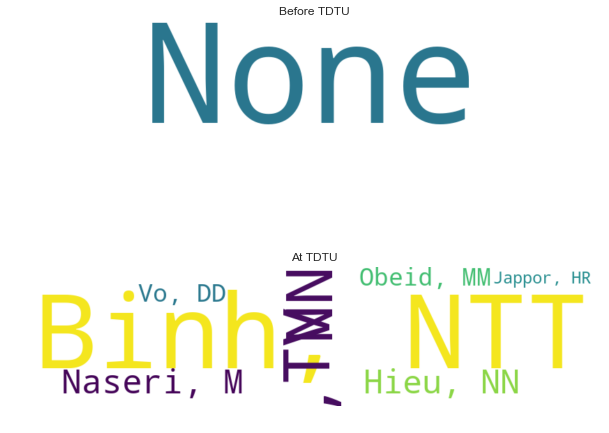

In [26]:
at_tdtu = df["Is_DMH_at_TDTU"]
rows = [~at_tdtu, at_tdtu]
titles = ["Before TDTU", "At TDTU"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)

for ax, row, title in zip(axes, rows, titles):
    wlist = []
    for s in df.loc[row, "Corr_Auth_Names"].dropna().values:
        wlist.extend(s.split(";"))
    
    wlist = [s.strip() for s in wlist if "Hoat" not in s]
    
    if len(wlist) == 0:
        wlist.append("None")
    
    plot_wordcloud(wlist, ax)
    ax.set_title(title)
    

# Number of self cites

In [27]:
at_tdtu = df["Is_DMH_at_TDTU"]
sole_corr_auth = df["Is_DMH_Sole_Corr_Auth"]
co_corr_auth = df["Is_DMH_Co-Corr_Auth"]

print("Average number of self cites before TDTU: %0.2f" % (df.loc[~at_tdtu, "Nr_Self_Cites_DMH"].mean() ) )

print("Average number of self cites at TDTU and DMH is sole corr. auth.: %0.2f" % (
    df.loc[at_tdtu & sole_corr_auth, "Nr_Self_Cites_DMH"].mean() ) )

print("Average number of self cites at TDTU and DMH is co-corr. auth.: %0.2f" % (
    df.loc[at_tdtu & co_corr_auth, "Nr_Self_Cites_DMH"].mean() ) )

Average number of self cites before TDTU: 0.06
Average number of self cites at TDTU and DMH is sole corr. auth.: 2.17
Average number of self cites at TDTU and DMH is co-corr. auth.: 1.25
